<a href="https://colab.research.google.com/github/aymanish/PADL-Q6-GAN-Clock-Image-Generator/blob/main/Q6_padl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Q6**

In [ ]:
# Import all relevant libraries
import zipfile
import os
import shutil
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import ConcatDataset
import torch.optim as optim

In [ ]:
# Get training device. This will be the CPU or GPU(cuda) depending on availability
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cuda:0 device


In [ ]:
# LOAD IMAGES

# Use wget to download the zip file
!wget https://www-users.york.ac.uk/~waps101/PADL/clocks_dataset.zip

Implemented seperate dalatoaders and directories for the GAN question to avoid conflicts between Q5 and Q6.

In [ ]:
# Extract the zip file
with zipfile.ZipFile("clocks_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("clocks_dataset_gan")

# List the extracted files
extracted_files = os.listdir("clocks_dataset_gan")
print(extracted_files)



['train']


In [ ]:
resize = 32

In [ ]:
# Filter for PNG files in the 'train' directory
train_dir = "clocks_dataset_gan/train"
png_files = [file for file in os.listdir(train_dir) if file.endswith('.png')]

print(f"PNG files: {png_files}")
print(f"Total number of images: {len(png_files)}")

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((resize, resize)),  # Resize to the desired size 32 # 128 # 448
    transforms.ToTensor(),          # Convert the image to a tensor with values in [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image to [-1, 1]
])

# Load and transform an image
if png_files:
    example_image_path = os.path.join(train_dir, png_files[0])
    image = Image.open(example_image_path)
    image = transform(image)
    print(image.shape)
else:
    print("No PNG files found in the directory.")



In [ ]:
# Uncomment and run if clocks_dataset_augmented already exists or requires changing without overwitting
"""
# Path to the directory to delete
directory_path = "clocks_dataset_augmented_gan"

# Remove the directory and all its contents
shutil.rmtree(directory_path)
#"""

All the images in  the basic transform as defined below where they are resized to 32 x 32 pixels. images are resized to for easier learning and memory capacity of the neural network.

Given most of the images are mostly empty color spaces we wuld not loose too much information by downscaling. Keeping them at 448 x448 would unnecessarily increase computation. Hence we resclae to about half while also ensuring we do not lose necessary features from the image such as numbers

THe are then converted to Tensors for the Pytorch based neural network and then then tensor image values are normalised between 0 and 1 for smoother learning as the values are now scaled. This transofrmation happens at the very end when the dataloaders are used to fetch the images from the directories.



---

We want to create a copy of the original images and apply transformations and augmentations to create new synthetic data to learn from.

* For these augmentations we have an augment_transform pipeline that applies the same resizing incase an image hasnt already been resized - ensuring consistency.  After that we also apply color jitter which augments the brightness, contrast, saturation and hue of all the images thus providing more variation. We kept them moderately low at 20% variations to the values mentioned above. This is so that we do not augment them too heavily and make our trainng data difficutlt to learn or too different from the test data. Having this accounts for colours and brightness levels that would otherwise be previously unseen thus allowing us to create more variations of clocks and not just copy the training data.

* We opted against transformations such as scaling and translations as we dont want the image to generate that are different or wrong such as rotate the wrong way or flipped horizontally. We assume the clocks were always facing the right way up as well - centered on the middle.

* We also apply minor gaussian blur and noise to the images with a 5% chance to allow the model to be more robust and generate more robust images. It also makes the generator train harder as the discriminator will have seen noisy images and thus can discern them., making the generators job to fool harder. Training a harder generator is beneficial as it makes the resulting images more robust. This complements the adverserial nature of the GAN, by adding small perturbations to the training data./ latent sample space

For each origianl image we create 4 augmentations which are stored in the augmented directory. We have 10000 original images. Hence we obtain 10000 x 4 = 40000 augmented images. This totals to a training size of 50,000 images. For GANS, this was desired as the more data we have that are diverse the better our results. This was also another reason why we reduced our images to 32 x32 for such a large capacity of images it would take too long to train but also store the iamges in collab.

In [ ]:
# PREPROCESS THE IMAGES AND IMPLEMENT AUGMENTATIONS
# Create a directory for augmented data
augmented_dir = "clocks_dataset_augmented_gan"
if os.path.exists(augmented_dir):
    shutil.rmtree(augmented_dir)
os.makedirs(augmented_dir)


augment_transform = transforms.Compose([
    transforms.Resize((resize, resize)),  # Resize to the desired size
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Apply color jitter with reduced intensity
    transforms.RandomApply([
        transforms.Lambda(lambda img: transforms.ToPILImage()(transforms.ToTensor()(img) + torch.randn_like(transforms.ToTensor()(img)) * 0.05))
    ], p=0.1),  # Add random noise and convert back to PIL Image
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2))], p=0.1)  # Apply Gaussian blur
])

print(f"Total number of original images: {len(png_files)}")

# Number of augmented images to generate per original image
num_augmentations = 4

# Generate and save augmented images
for img_file in png_files:
    image = Image.open(os.path.join(train_dir, img_file)).convert('RGB')
    for i in range(num_augmentations):
        augmented_image = augment_transform(image)
        augmented_image_path = os.path.join(augmented_dir, f"{img_file.split('.')[0]}_aug_{i}.png")
        augmented_image.save(augmented_image_path)

# Verify augmented dataset size
augmented_files = [file for file in os.listdir(augmented_dir) if file.endswith('.png')]
print(f"Total number of augmented images: {len(augmented_files)}")


Total number of original images: 10000
Total number of augmented images: 40000


In [ ]:
# Custom dataset class for loading original images
class PNGDataset(Dataset):
    def __init__(self, image_dir, image_files, transform=None):
        self.image_dir = image_dir
        self.image_files = image_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Custom dataset class for loading augmented images
class AugmentedPNGDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [file for file in os.listdir(image_dir) if file.endswith('.png')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image




In [ ]:
# HYPER PARAMETER SETUP

batch_size = 100
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
num_epochs = 20#100 # Number of training epochs
lr = 0.0002  # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers

In [ ]:
# Create the original dataset and dataloader
original_dataset = PNGDataset(train_dir, png_files, transform=transform)
original_dataloader = DataLoader(original_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# Create the augmented dataset and dataloader
augmented_dataset = AugmentedPNGDataset(augmented_dir, transform=transform)
augmented_dataloader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# Combine the original and augmented datasets
dataset = ConcatDataset([original_dataset, augmented_dataset])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# should be 3 x 32 x 32 for all

original_image = dataset[0]
print(original_image.shape)

augmented_image = dataset[0]
print(augmented_image.shape)

image = dataset[0]
print(image.shape)

torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


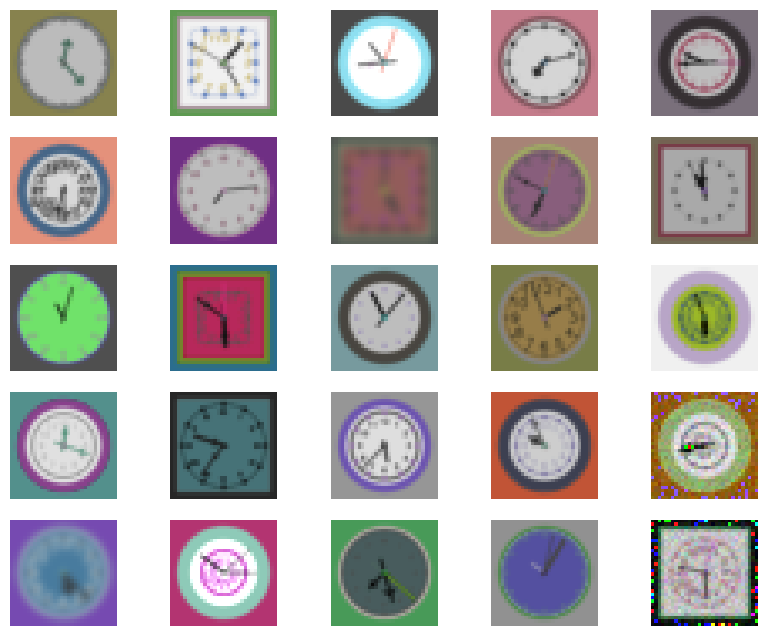

In [ ]:
import matplotlib.pyplot as plt
# check augmented images

images = next(iter(augmented_dataloader))  # Only get the images since no labels are returned

# Function to denormalize the images
def denormalize(tensor):
    return tensor * 0.5 + 0.5  # Reverse the normalization: (tensor * std + mean)

# Create a plot to visualize the images
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

for i in range(cols * rows):
    img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and rearrange dimensions
    img = denormalize(img)  # Reverse the normalization

    figure.add_subplot(rows, cols, i + 1)
    plt.axis("off")
    plt.imshow(img)

plt.show()


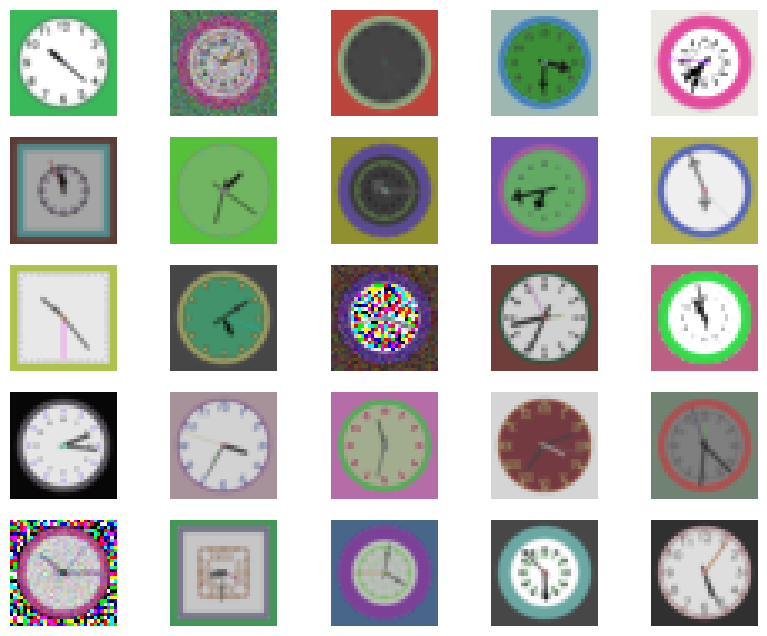

In [ ]:
import matplotlib.pyplot as plt
# check full new dataset of original + augmented images

images = next(iter(dataloader))  # Only get the images since no labels are returned

# Function to denormalize the images
def denormalize(tensor):
    return tensor * 0.5 + 0.5  # Reverse the normalization: (tensor * std + mean)

# Create a plot to visualize the images
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

for i in range(cols * rows):
    img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and rearrange dimensions
    img = denormalize(img)  # Reverse the normalization

    figure.add_subplot(rows, cols, i + 1)
    plt.axis("off")
    plt.imshow(img)

plt.show()


The code blocks below refer to part (a and b) of Question 6:

Our model for the network architecture takes inspiration from the DCGAN - Deep Convolutional Generative Adversarial network.

It includes a generator that is trying to distinguish real from fake samples/ images that are generated by the generator from a random sample from the latent space.

The generator is trying to create samples  that fool the discriminator .

THe discriminator is a binary classification network that outputs the scalar Dx.
The generator samples a random z and forward passes thorugh the generator to create fake sample x'. We pass the fake sample throught he discriminator and compute the binary cross entropy loss with the wrong label and backpropto update only the generator.

In [ ]:
# DEFINE GAN NETWORK
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z of size B x nz x 1 x 1, we put this directly into a transposed convolution
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Size: B x (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Size: B x (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Size: B x (ngf) x 16 x 16
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            # Size: B x 3 x 32 x 32
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

netG = Generator()
netG = netG.to(device)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # state size. 3 x 32 x 32
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

netD = Discriminator()
netD = netD.to(device)

GANS are nototiosly difficult to train. We use the same hyperparams and network structure decision as DCGAN such as using strided convolutions for upsamplign and downsampling, use batch norm in both Generator and Discriminator and use the leaky ReLU activation function in  the discriminator.

We also normalise to -1 and 1 since this is better for GANS and use the Adam optimiser with a lower momentum coefficient that usual at 0.002 for the discriminator and a lower learning rate for the generator at 0.0001. This was done as in the initial runs the Generator struggled to fool the Discriminator and so we made it learn better by reducing the rate.

For the simple task of clock generation  the binary cross entropy loss worked quite well. However, to make the generator better at fooling the discriminator we could use the wasserstein GAN loss function.

In [ ]:
# TRAINING LOOP IMPLEMENTATION
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0001, betas=(beta1, 0.999))

# Training Loop

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, images in enumerate(dataloader, 0):  # CHANGED: Remove labels from the unpacking


        # (1) Update Discriminator network: maximize log(D(x)) + log(1 - D(G(z)))

        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_images = images.to(device)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)  # CHANGED: Adjust label size to match batch
        # Forward pass real batch through D
        output = netD(real_images).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        z = torch.randn(batch_size, nz, 1, 1, device=device)  # CHANGED: Adjust z size to match batch
        # Generate fake image batch with G
        fake = netG(z)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()


        # (2) Update Generator network: maximize log(D(G(z)))

        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))


In [ ]:
# SAVE MODEL
import torch

# Define file paths
generator_path = "generator.pth"
discriminator_path = "discriminator.pth"
optimizerG_path = "optimizerG.pth"
optimizerD_path = "optimizerD.pth"

# Save the generator, discriminator, and optimizers
torch.save(netG.state_dict(), generator_path)
torch.save(netD.state_dict(), discriminator_path)
torch.save(optimizerG.state_dict(), optimizerG_path)
torch.save(optimizerD.state_dict(), optimizerD_path)

print("Models and optimizers have been saved.")


Models and optimizers have been saved.


part c:
We successuflly obtain discernable clocks with a diverse range of colours and shapes and backgrounds. We can clearly make out the clock hands as well as the marks for the times. Althoguh with such a low res of 32 x 32 we cannot generate an y clear numbers. Overall the GAN produces images of clocks successfully.

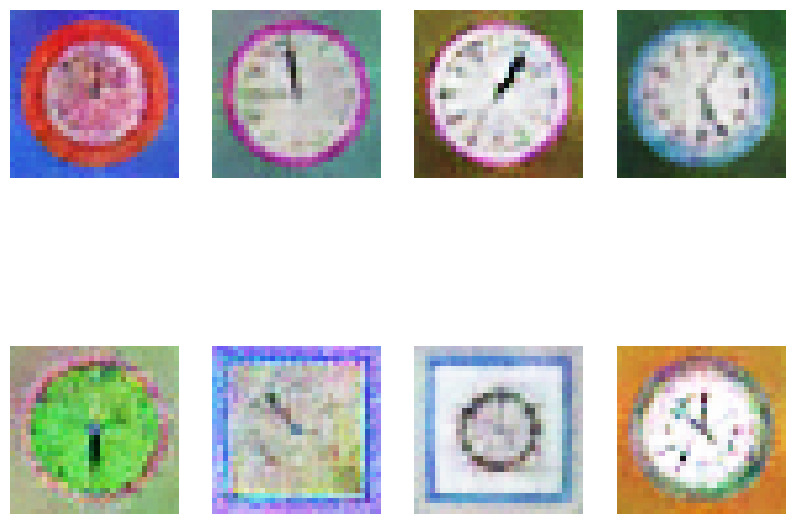

In [ ]:

# Successfully generate 8 random clock images (marks awarded depending on image quality)
# Solution
z = torch.randn(8, nz, 1, 1, device=device)  # CHANGED: Generate 8 random latent vectors
images = netG(z)

# Create a plot to visualize the images
figure = plt.figure(figsize=(10, 8))
cols, rows = 4, 2  # CHANGED: Adjust the grid to 4 columns and 2 rows for 8 images

for i in range(cols * rows):
    img = images[i].permute(1, 2, 0).cpu().detach().numpy()  # Convert tensor to numpy array and rearrange dimensions
    img = (img + 1) / 2  # Reverse the normalization: scale from [-1, 1] to [0, 1]

    figure.add_subplot(rows, cols, i + 1)
    plt.axis("off")
    plt.imshow(img)

plt.show()


part d:
We successfully achieve latent interpolation across 2 clock images as we see the shape change form a curcle to a square and the time (clock hands) also change.

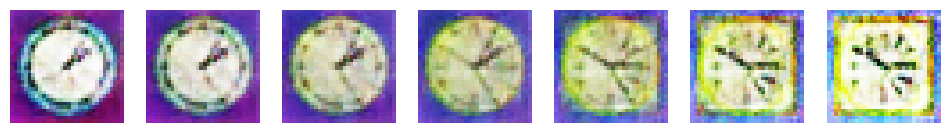

In [ ]:
# Successfully interpolate between two random clock images in latent space.

nsamples = 7  # CHANGED: Number of samples to interpolate, including the two endpoints
z1 = torch.randn(1, nz, 1, 1, device=device)
z2 = torch.randn(1, nz, 1, 1, device=device)
z = torch.zeros(nsamples, nz, 1, 1, device=device)

for i in range(nsamples):
    w1 = i / (nsamples - 1)
    w2 = 1 - w1
    z[i, :, :, :] = w1 * z1 + w2 * z2

images = netG(z)

# Create a plot to visualize the images
figure = plt.figure(figsize=(12, 4))
for i in range(nsamples):
    figure.add_subplot(1, nsamples, i + 1)
    plt.axis("off")
    img = images[i].permute(1, 2, 0).cpu().detach().numpy()  # Convert tensor to numpy array and rearrange dimensions
    img = (img + 1) / 2  # Reverse the normalization: scale from [-1, 1] to [0, 1]
    plt.imshow(img)

plt.show()
